In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

#from sklearn.feature_selection import RFE

In [3]:
df = pd.read_csv('../../mod-2-project/data/kc_house_data_2.csv', index_col=0)

In [4]:
display(df.dtypes)
display(df.shape)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

(21534, 21)

In [5]:
df['age_home'] = 2020 - df['yr_built']

In [6]:
df.isnull().sum().sum()

0

### Correlation Analysis

In [7]:
price_corr = df.corr()['price']
top_price_corr = price_corr[abs(price_corr) > 0.50].sort_values(ascending=False)

In [8]:
top_price_corr

price            1.000000
sqft_living      0.701587
grade            0.668307
sqft_above       0.605695
sqft_living15    0.585304
bathrooms        0.525053
Name: price, dtype: float64

In [9]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    

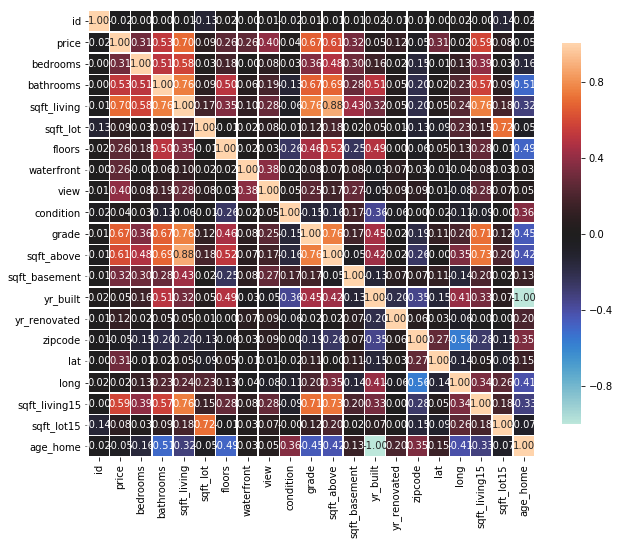

In [10]:
correlation_heatmap(df)

### Log Transformation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c17ab9550>,
      dtype=object)

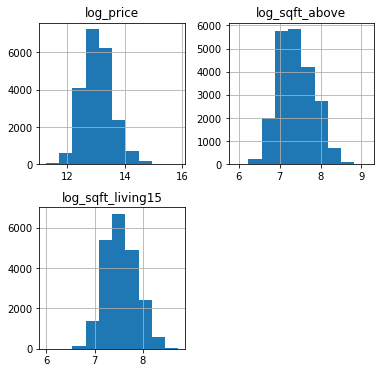

In [11]:
data_log = pd.DataFrame([])
data_log['log_price'] = np.log(df['price'])
data_log['log_sqft_above'] = np.log(df['sqft_above'])
data_log['log_sqft_living15'] = np.log(df['sqft_living15'])
data_log.hist(figsize  = [6, 6])

### Standardization 

In [13]:
logprice = data_log['log_price']
logsqft_above = data_log['log_sqft_above'] 
logsqft_living15 = data_log['log_sqft_living15'] 

scaled_price = (logprice - np.mean(logprice)) / np.sqrt(np.var(logprice))
scaledsqft_above = (logsqft_above - np.mean(logsqft_above)) / np.sqrt(np.var(logsqft_above))
scaledsqft_living15 = (logsqft_living15 - np.mean(logsqft_living15)) / np.sqrt(np.var(logsqft_living15))

target = pd.DataFrame()

target['log_price'] = scaled_price
df['sqft_above_trans'] = scaledsqft_above
df['sqft_living15_trans'] = scaledsqft_living15
 
#data_cont_scaled.hist(figsize = [6, 6]);

### Decomposing Categories

In [14]:
# Excluding price for encoding
x_cols = df.iloc[:, 3:]
x_cols = list(x_cols.columns.values)

In [15]:
categorical_variables = ['zipcode']

In [16]:
df_ohe = pd.get_dummies(df[x_cols], columns= categorical_variables, drop_first = True )

In [17]:
df_ohe.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,...,0,0,0,0,0,0,1,0,0,0
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,...,0,0,0,0,0,0,0,0,0,0
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,...,0,0,0,0,0,0,0,0,0,0
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,...,0,0,0,0,0,0,0,0,0,0
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_ohe.columns

Index([u'bedrooms', u'bathrooms', u'sqft_living', u'sqft_lot', u'floors',
       u'waterfront', u'view', u'condition', u'grade', u'sqft_above',
       u'sqft_basement', u'yr_built', u'yr_renovated', u'lat', u'long',
       u'sqft_living15', u'sqft_lot15', u'age_home', u'sqft_above_trans',
       u'sqft_living15_trans', u'zipcode_98002', u'zipcode_98003',
       u'zipcode_98004', u'zipcode_98005', u'zipcode_98006', u'zipcode_98007',
       u'zipcode_98008', u'zipcode_98010', u'zipcode_98011', u'zipcode_98014',
       u'zipcode_98019', u'zipcode_98022', u'zipcode_98023', u'zipcode_98024',
       u'zipcode_98027', u'zipcode_98028', u'zipcode_98029', u'zipcode_98030',
       u'zipcode_98031', u'zipcode_98032', u'zipcode_98033', u'zipcode_98034',
       u'zipcode_98038', u'zipcode_98039', u'zipcode_98040', u'zipcode_98042',
       u'zipcode_98045', u'zipcode_98052', u'zipcode_98053', u'zipcode_98055',
       u'zipcode_98056', u'zipcode_98058', u'zipcode_98059', u'zipcode_98065',
       u'zi

### Modeling

In [19]:
df_ohe.isnull().sum().sum()

0

In [34]:
## This time note that we are using all of the independent variables 'TV', 'Newspaper', 'Radio'
X = df_ohe.values

## Target variable (Dependent Variable) is still 'Sales' column
y = target.log_price.values

## We need to add constants for the intercept term
Xconst = sm.add_constant(X)

## Note that the rest is exactly the same with the simple linear regression
model = sm.OLS(y, Xconst, hasconst= True)
multiple_model_fitted = model.fit()
print(multiple_model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     1838.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:10:19   Log-Likelihood:                -7568.3
No. Observations:               21534   AIC:                         1.531e+04
Df Residuals:                   21446   BIC:                         1.601e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.052e-05   6.47e-06     -9.355      0.0

#### 88% of the variations in Price are explained by the independent variables in our model.

### Stepwise selection with p-values

[With help from this stackexchange post](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm

In [50]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [66]:
result = stepwise_selection(df_ohe, target.log_price, verbose=True)
print('resulting features:')
print(result)

Add  grade                          with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  yr_built                       with p-value 0.0
Drop sqft_basement                  with p-value 0.140685


/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  age_home                       with p-value 0.0
Add  view                           with p-value 1.16942e-241
Add  zipcode_98004                  with p-value 3.28212e-268
Add  zipcode_98155                  with p-value 2.05883e-139
Add  zipcode_98133                  with p-value 1.0897e-133
Add  zipcode_98040                  with p-value 2.00349e-132
Add  zipcode_98112                  with p-value 2.25981e-119
Add  zipcode_98028                  with p-value 3.11381e-108
Add  condition                      with p-value 2.15084e-100
Add  sqft_living15_trans            with p-value 6.2298e-94
Add  floors                         with p-value 3.23661e-98
Add  zipcode_98019                  with p-value 4.06581e-95
Add  zipcode_98039                  with p-value 1.19576e-86
Add  zipcode_98168                  with p-value 4.55209e-86
Add  waterfront                     with p-value 3.17167e-85
Add  zipcode_98011                  with p-value 5.79945e-85
Add  zipcode_98072        

### New Model after removing p-values through stepwise

In [71]:
X = df_ohe[result]
y = target.log_price
Xconst = sm.add_constant(X)

model = sm.OLS(y, Xconst, hasconst= True)
multiple_model_fitted = model.fit()
print(multiple_model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     2055.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:11:05   Log-Likelihood:                -7671.1
No. Observations:               21534   AIC:                         1.550e+04
Df Residuals:                   21456   BIC:                         1.612e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.351e-05   1

### Normality Check

#### Find residiuals and check distributions

(array([9.0000e+00, 1.4000e+01, 8.3000e+01, 4.9900e+02, 2.9370e+03,
        1.1261e+04, 5.8690e+03, 7.2500e+02, 1.1100e+02, 2.6000e+01]),
 array([-2.41055473, -1.98494657, -1.55933841, -1.13373024, -0.70812208,
        -0.28251392,  0.14309424,  0.5687024 ,  0.99431057,  1.41991873,
         1.84552689]),
 <a list of 10 Patch objects>)

AttributeError: 'module' object has no attribute 'norm'

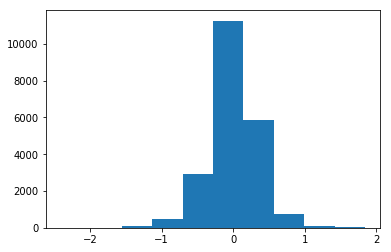

In [42]:
residuals = multiple_model_fitted.resid
display(plt.hist(residuals))

fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
display(fig.show())

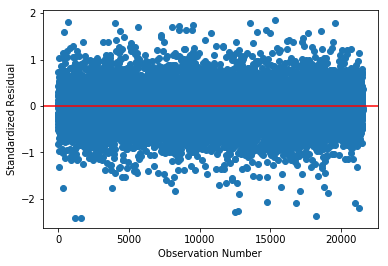

In [48]:
fig2=plt.plot(residuals, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')
print(fig2)

#### Standard normal distribution. 97% of residual values fall between 1 standard deviation. 

### 80/20 Train Test Split to find best fit line

In [75]:
#change df_ohe to a numpy array for training
x_array = df_ohe.to_numpy()

#change housing price serie to a numpy array
y_array = target.log_price.to_numpy()

In [77]:
#split data into 80% test and 20% train
X_train, X_test, y_train, y_test = train_test_split(x_array, y_array, test_size=0.2, random_state=50)

In [78]:
# To find the best fit line:
lr = LinearRegression()
model = lr.fit(X_train, y_train)

# coefficients (m slope)
m = lr.coef_

# y-intercept b
b = lr.intercept_

### Cross-Validation

In [80]:
cv_5_results  = (cross_val_score(lr, X_train, y_train, cv=5,  scoring='r2'))
cv_5_results.mean()

0.8807797294352187

In [82]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

### Test for Underfitting and Overtfitting

In [83]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

# ('Train Mean Squarred Error:', 0.11743989775683308)
# ('Test Mean Squarred Error:', 0.12234187396714999)

# Results do not show big difference between the train and test MSE.

('Train Mean Squarred Error:', 0.11743989775683308)
('Test Mean Squarred Error:', 0.12234187396714999)


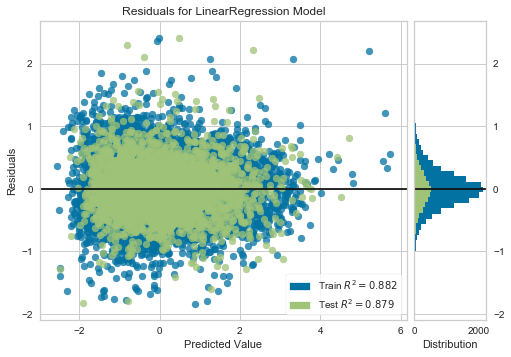

In [102]:
#create a residual map

#Instantiate the linear model and visualizer
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Finalize and render the figure